In [40]:
import pandas as pd
import numpy as np
from scipy import stats
import math
from pandas import Series
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from numpy import log
%matplotlib inline

In [19]:
male_data = pd.read_csv('Male Data.csv')
female_data = pd.read_csv('Female Data.csv')

In [20]:
male_data.set_index ('REF_DATE', inplace = True)
female_data.set_index ('REF_DATE', inplace = True)

In [21]:
male_data.drop(labels=['DGUID','UOM','UOM_ID','SCALAR_FACTOR','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED','DECIMALS','Age group'], axis=1, inplace=True)
female_data.drop(labels=['DGUID','UOM','UOM_ID','SCALAR_FACTOR','SCALAR_ID','VECTOR','COORDINATE','STATUS','SYMBOL','TERMINATED','DECIMALS','Age group'], axis=1, inplace=True)

In [22]:
male_data.rename(columns = {'GEO':'Province', 'Duration of unemployment':'Duration', 'VALUE':'Total_Unemployed'}, inplace = True)
female_data.rename(columns = {'GEO':'Province', 'Duration of unemployment':'Duration', 'VALUE':'Total_Unemployed'}, inplace = True)

In [23]:
male_data = male_data[male_data.Duration != '26 weeks']
female_data = female_data[female_data.Duration != '26 weeks']

In [24]:
male_data["Total_Unemployed"].fillna(male_data.groupby("Province")["Total_Unemployed"].transform("mean"), inplace=True)
female_data["Total_Unemployed"].fillna(female_data.groupby("Province")["Total_Unemployed"].transform("mean"), inplace=True)

In [25]:
male_data['Rounded_Total'] = male_data['Total_Unemployed'].round(decimals = 1)
female_data['Rounded_Total'] = female_data['Total_Unemployed'].round(decimals = 1)

In [11]:
on_male_data = male_data[(male_data['Duration']=='14 to 25 weeks') & (male_data['Province']=='Ontario')]
on_female_data = female_data[(female_data['Duration']=='14 to 25 weeks') & (female_data['Province']=='Ontario')]

In [26]:
on_male_values = on_male_data['Rounded_Total'].tolist()
on_female_values = on_female_data['Rounded_Total'].tolist()

In [27]:
bc_male_data = male_data[(male_data['Duration']=='14 to 25 weeks') & (male_data['Province']=='British Columbia')]
bc_female_data = female_data[(female_data['Duration']=='14 to 25 weeks') & (female_data['Province']=='British Columbia')]

In [28]:
bc_male_values = bc_male_data['Rounded_Total'].tolist()
bc_female_values = bc_female_data['Rounded_Total'].tolist()
on_male_values = on_male_data['Rounded_Total'].tolist()
on_female_values = on_female_data['Rounded_Total'].tolist()

### Hypothesis Test for BC Data

Because this a time series data we have be careful when computing the t statistic </br>
we have to make sure that our data is stationary (no strong autocorrelation) and we also need to make sure that there is no strong seaonality in the data.

checking for seasonality

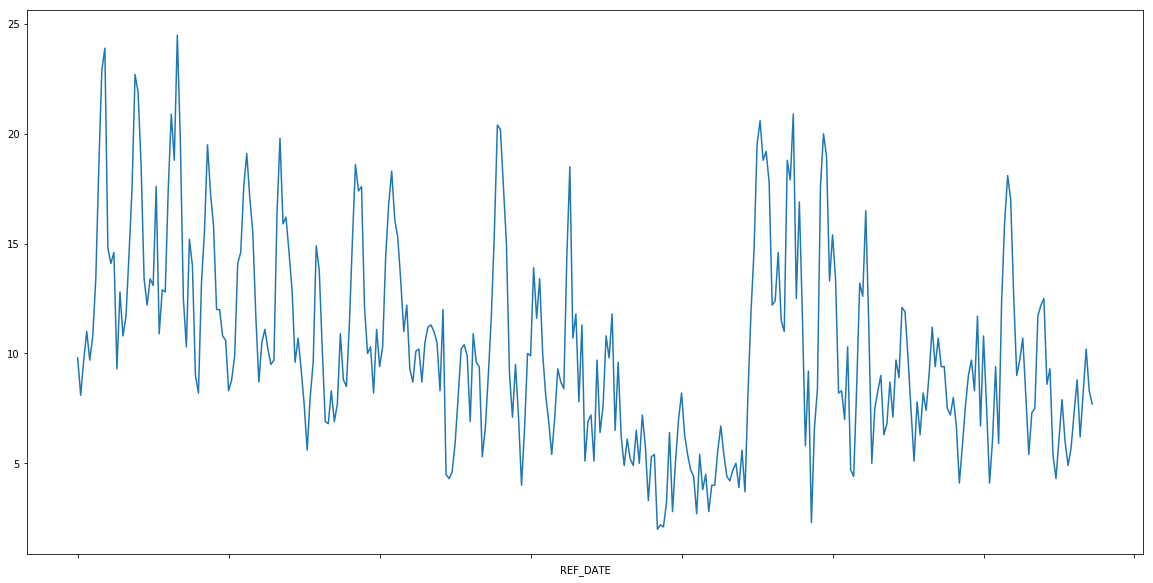

In [38]:
bc_male_data['Rounded_Total'].plot(figsize=(20,10))

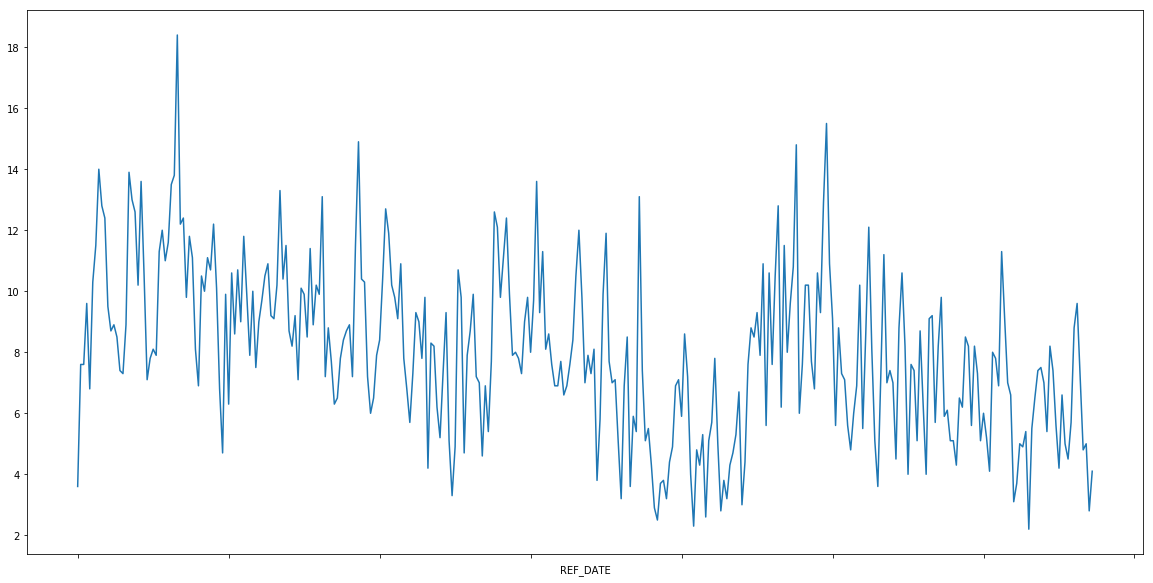

In [39]:
bc_female_data['Rounded_Total'].plot(figsize=(20,10))

##### the data looks almost random and there is no strong indication of seasonality or overall upwards or downward trend

now we check if the data is stationary (not autocorrelated or trending) using the Augmented Dickey–Fuller test </br>

we need to log transorm the data to have a more accurate result

In [41]:
series = bc_male_data['Rounded_Total']
X = series.values
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.142298
p-value: 0.023577
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [42]:
series = bc_female_data['Rounded_Total']
X = series.values
X = log(X)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.687502
p-value: 0.437563
	1%: -3.451
	5%: -2.870
	10%: -2.572


#### we can see that both computed p-values are lower than the alpha, therefore we can confirm our data is most likely to be stationary

## t-statistic

Checking for normal distribution

(array([18., 51., 70., 72., 47., 27., 23., 18.,  7.,  4.]),
 array([ 2.  ,  4.25,  6.5 ,  8.75, 11.  , 13.25, 15.5 , 17.75, 20.  ,
        22.25, 24.5 ]),
 <a list of 10 Patch objects>)

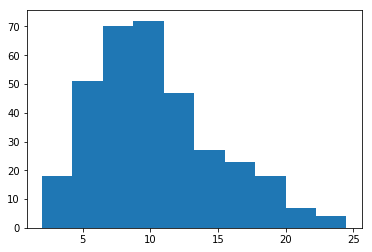

In [47]:
plt.hist(bc_male_values)

Computing the confidence interval

(array([21., 46., 55., 83., 63., 40., 20.,  7.,  1.,  1.]),
 array([ 2.2 ,  3.82,  5.44,  7.06,  8.68, 10.3 , 11.92, 13.54, 15.16,
        16.78, 18.4 ]),
 <a list of 10 Patch objects>)

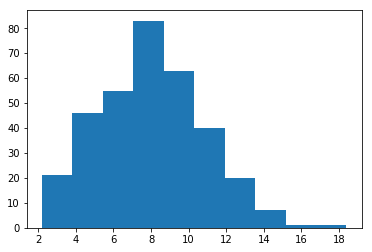

In [45]:
plt.hist(bc_female_values)

Both distribution look almost noraml with a slight skew, this however will not greatly impact our t-statistic as our sample size is small

In [48]:
CE = np.mean(bc_male_values) - np.mean(bc_female_values)
print ('The confidence interval is', CE)

The confidence interval is 2.3344213649851646


In [49]:
bc_len_male = bc_male_values.__len__()
bc_len_female = bc_female_values.__len__()

bc_male_mean = np.mean(bc_male_values)
bc_female_mean = np.mean(bc_female_values)

bc_male_sd = np.std(bc_male_values, ddof=1)
bc_female_sd = np.std(bc_female_values, ddof=1)

se_bc = np.sqrt((bc_male_sd**2)/(bc_len_male) + (bc_female_sd**2)/(bc_len_female))

In [50]:
bc_t_statistic = (bc_male_mean - bc_female_mean) / se_bc
print("t-statistic is %.4f" % bc_t_statistic)
bc_p_val = stats.t.sf(np.abs(bc_t_statistic), bc_len_male-1) * 2
print("p-value is %.18f" % bc_p_val)

t-statistic is 8.0286
p-value is 0.000000000000016748


In [51]:
stats.ttest_ind(bc_male_values, bc_female_values)

Ttest_indResult(statistic=8.028607217127051, pvalue=4.413657225964432e-15)

we can reject the null, there is a difference between the means of male and female data